# Clean file with modules

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import inverse_mapping_functions as imf
import Siamese_Architecture as SA

import umap.umap_ as umap
import tqdm
plt.rcParams['image.origin'] = 'lower'

BATCH_SIZE = 64

In [2]:
# dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc"
dataset_path = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc"
dataset = SproutDataset(dataset_path=dataset_path, augmentation_type='single', log_space=True, normalize_intensity=True)
dataloader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True)

In [3]:
# checkpoint = "C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\\Individual project\\SPICE_DeepLearning\\CUrc\\64-single-fulldata_gain01-3\\epoch=10-step=91500.ckpt"
# model = SA.SimSiam.load_from_checkpoint(checkpoint)  # Continue epochs 

model = SA.SimSiam(output_dim=32, backbone_output_dim=128, hidden_layer_dim=128)

# wandb_logger = WandbLogger(project="FullDataset_64_singleAug")#, log_model=True)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
trainer = pl.Trainer(max_epochs=5, devices=1, accelerator=accelerator)#, logger=wandb_logger)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | backbone        | Siamese1DNet_backbone | 924 K  | train
1 | projection_head | SimSiamProjectionHead | 37.4 K | train
2 | prediction_head | SimSiamPredictionHead | 8.5 K  | train
3 | criterion       | NTXentLoss            | 0      | train
------------------------------------------------------------------
970 K     Trainable params


Epoch 4: 100%|██████████| 1830/1830 [02:53<00:00, 10.53it/s, v_num=26]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1830/1830 [02:53<00:00, 10.53it/s, v_num=26]


In [5]:
dataset_none = SproutDataset(dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", augmentation_type=None)
# outputs = SA.run_model(checkpoint, dataset_none)
model.eval()
outputs = []
with torch.no_grad():  # Disable gradient computation for inference
    for i in tqdm.tqdm(range (dataset_none.__len__())):
        spec = dataset_none.__getitem__(i).unsqueeze(0)
        # Move tensor to the same device as the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        spec = spec.to(device)

        outputs.append(model(spec)[0].cpu().numpy())

100%|██████████| 117120/117120 [04:38<00:00, 420.43it/s]


In [2]:
checkpoint = "C:\\Users\\tania\Documents\CU Boulder\CU Alpine\models_ckpts\single_epoch=4-step=45750.ckpt"
dataset_none = SproutDataset(dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", augmentation_type=None)
outputs = SA.run_model(checkpoint, dataset_none)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\tania\Documents\CU Boulder\CU Alpine\models_ckpts\single_epoch=4-step=45750.ckpt`
100%|██████████| 117120/117120 [05:35<00:00, 349.52it/s]


In [6]:
stacked_outputs = np.stack(outputs).squeeze()
stacked_outputs.shape

(117120, 32)

In [7]:
np.save('saved_outputs//stacked_outputs_single64_feb23_norm_log.npy', stacked_outputs)

In [5]:
stacked_outputs = np.load('saved_outputs//stacked_outputs_single64_feb23_norm.npy')

In [7]:
for x in [10, 20, 30]:
# for x in [20, 30]:
    for y in tqdm.tqdm([2, 5, 10]):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean') # <=> cosine?
        clusterer.fit(stacked_outputs)
        labels = clusterer.labels_
        np.save(f'saved_outputs//norm_out32_Feb23_minclus{x}_minsamp{y}.npy', labels)

100%|██████████| 3/3 [00:52<00:00, 17.49s/it]


Unique Clusters: [-1  0  1  2  3  4]
Unique Clusters: [-1  0  1  2  3  4]
Unique Clusters: [-1  0  1]
Unique Clusters: [-1  0  1]
Unique Clusters: [-1  0  1  2  3  4  5  6]
Unique Clusters: [-1  0  1]
Unique Clusters: [-1  0  1]
Unique Clusters: [-1  0  1  2  3]
Unique Clusters: [-1  0  1]


Text(0.5, 0.98, 'norm_out32_Feb23_minclus_single')

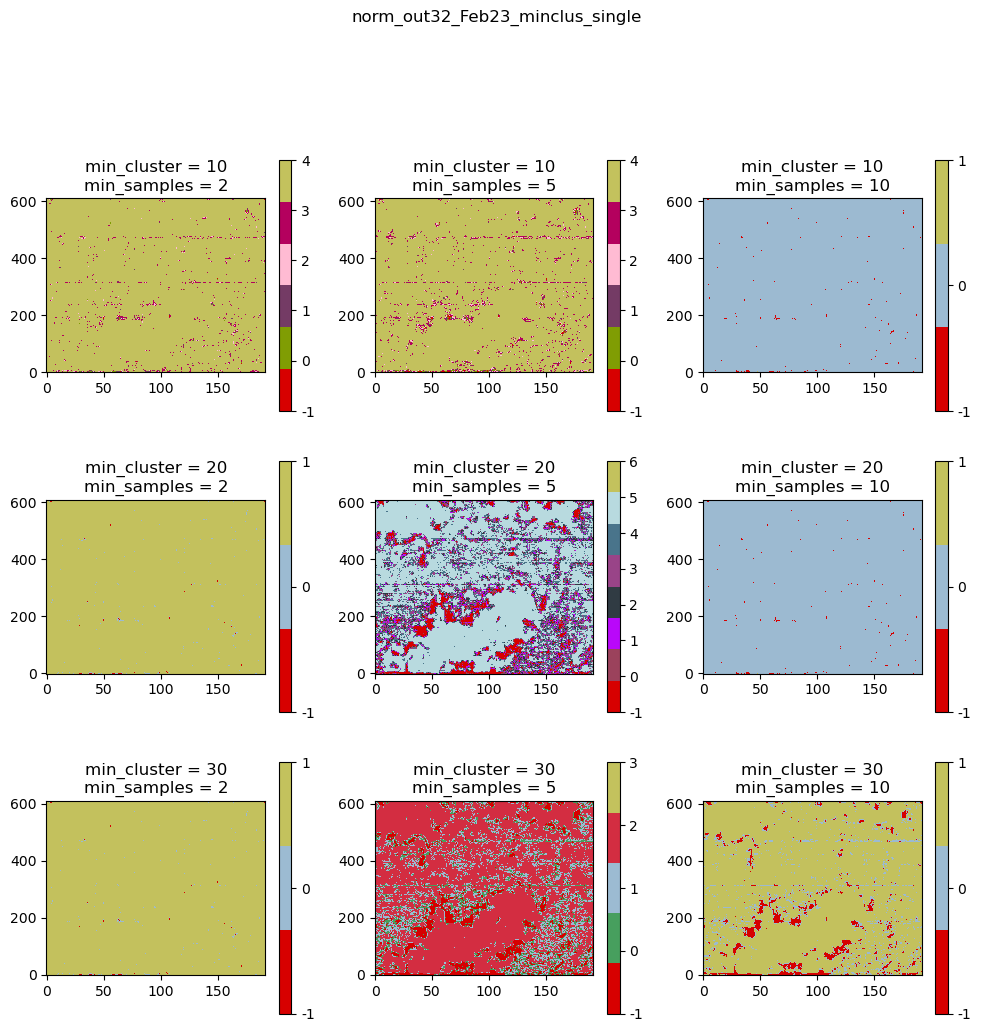

In [8]:
c=0
plt.figure(figsize=(12,15))
for x in [10, 20, 30]:
    for y in [2, 5, 10]:
        c+=1
        plt.subplot(4,3,c)
        labels = np.load(f'saved_outputs//norm_out32_Feb23_minclus{x}_minsamp{y}.npy')
        # labels = np.load(f"C:\\Users\\tania\Documents\\CU Boulder\CU Fall 2024\\ASEN 6337\\Individual project\\SPICE_DeepLearning\saved_outputs_1Apr25\labels-cos_single64_Feb23_minclus{x}_minsamp{y}.npy")
        imf.map_clusters(labels, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", selected_clusters=None)
        plt.title(f"min_cluster = {x}\nmin_samples = {y}")
plt.suptitle('norm_out32_Feb23_minclus_single')
        

In [7]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
projected_data = reducer.fit_transform(stacked_outputs)

In [8]:
#np.save('saved_outputs//umap_data_64sin_fulldata_nei15_dist01_50_5.npy', projected_data)

In [7]:
projected_data = np.load('saved_outputs//umap_data_64sin_fulldata_nei15_dist01_50_5.npy')
# stacked_outputs = np.load('saved_outputs//stacked_outputs_64_fulldata.npy')
#labels = np.load('saved_outputs//labels_single64_fulldata_minclus50_minsamp5_unnormalized.npy')

In [12]:
from matplotlib.colors import Normalize

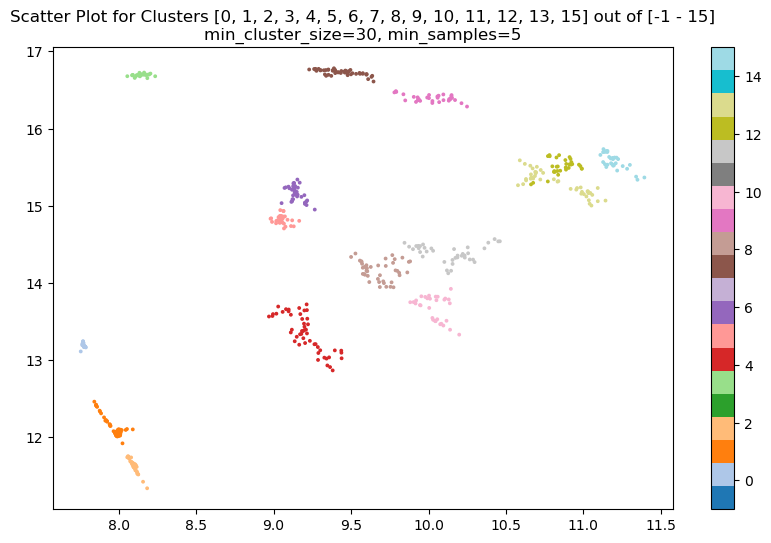

In [16]:
target_clusters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]  # List of cluster labels to plot
selected_points = projected_data[np.isin(labels, target_clusters)]
selected_labels = labels[np.isin(labels, target_clusters)]
norm = Normalize(vmin=labels.min(), vmax=labels.max())

plt.figure(figsize=(10, 6))
plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='tab20', norm=norm, s=3)
plt.title(f"Scatter Plot for Clusters {target_clusters} out of [{labels.min()} - {labels.max()}]\nmin_cluster_size=30, min_samples=5")
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(10, 14))
plt.subplot(211)
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='tab20', s=1)
plt.colorbar()
plt.title('UMAP Projection to 2D')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.subplot(212)
plt.hist2d(projected_data[:, 0], projected_data[:, 1], bins=200)
plt.colorbar()
plt.grid(True)
plt.title('Density histogram')
plt.show()

In [9]:
labels = np.load('saved_outputs//clustered_outputs_single64_fulldata_minclus50_minsamp5.npy')

In [ ]:
imf.map_clusters(labels, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train.nc", selected_clusters=None)

solo_L2_spice-n-ras_20230211T153421_V22_167772557-000.fits
(40, 610, 192)


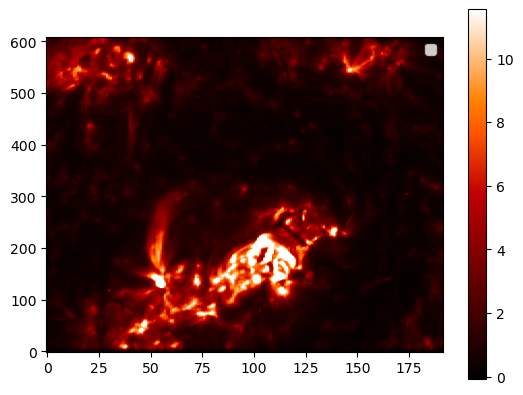

In [15]:
imf.map_item_map(item_nbr=9899, dataset="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", plot=False, title=' ')

labels shape:  (1171200, 1)
Items selected :  [1160822  915532  917647]


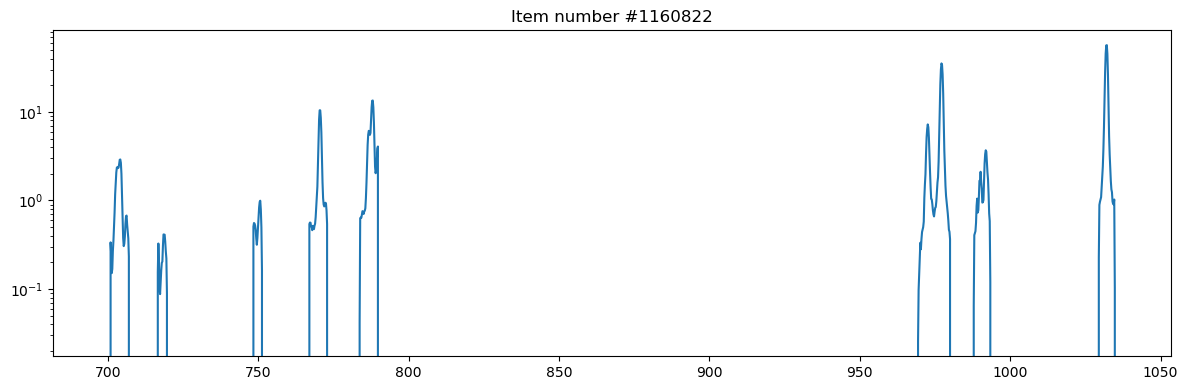

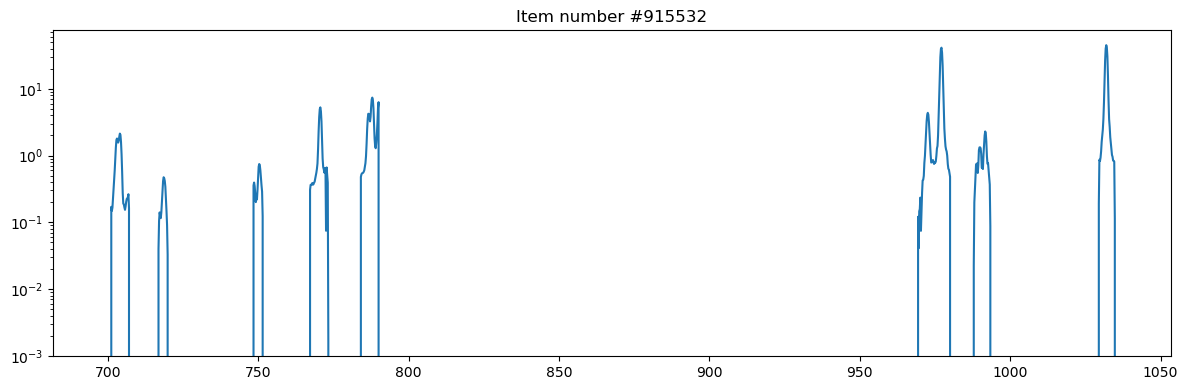

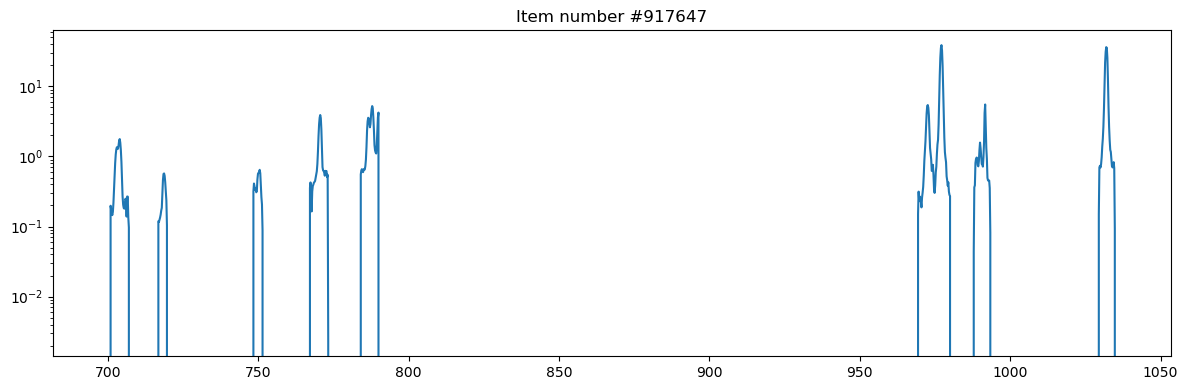

IndexError: range object index out of range

In [25]:
imf.plot_n_random_spectra_cluster(labels, stacked_outputs, 1, dataset, nbr_items=3, plot_on_map=True,
                                  dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_train_mini.nc")